In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)), names=columns)
    df.columns = df.columns.str.strip()
    return df

directory = 'heterogeneity_exp/5'

pattern = re.compile('result_monocore_(\d?\d).csv')

def read_file(archive_name, csv_name, columns=None):
    df = read_csv(archive_name, csv_name, columns)
    info = yaml.load(zipfile.ZipFile(archive_name).read('info.yaml'))
    nodes = [key for key in info if key.endswith('grid5000.fr')]
    assert len(nodes) == 1
    node = nodes[0]
    node = node[:node.index('.')]
    node = int(node[node.index('-')+1:])
    df['node'] = node
    df['index'] = range(len(df))
    df['index_in_seq'] = df['index'] % 3
    df['first_index'] = df['index_in_seq'] == 0
    match = pattern.match(csv_name)
    assert match
    core_index = int(match.groups()[0])
    df['core'] = core_index
    return df

def read_archive(archive_name, columns=None):
    data = []
    for file in zipfile.ZipFile(archive_name).namelist():
        if pattern.match(file):
            data.append(read_file(archive_name, file, columns=columns))
    return pandas.concat(data)

def read_dir(directory, columns=None):
    data = []
    for file in os.listdir(directory):
        if file.endswith('.zip'):
            data.append(read_archive(os.path.join(directory, file), columns=columns))
    return pandas.concat(data, ignore_index=True)

columns = ['function', 'm', 'n', 'k', 'timestamp', 'duration']

df = read_dir(directory, columns)
df['size_product'] = df.m * df.n * df.k

print(len(df))
df.head()

8640000


,function,m,n,k,timestamp,duration,node,index,index_in_seq,first_index,core,size_product
0,dgemm,6,230,44,1163.904496,3.712100e-05,2,0,0,True,0,60720
1,dgemm,6,230,44,1163.904557,1.693200e-05,2,1,1,False,0,60720
2,dgemm,6,230,44,1163.904576,2.938100e-05,2,2,2,False,0,60720
3,dgemm,5,46,2,1163.904608,2.062000e-06,2,3,0,True,0,460
4,dgemm,5,46,2,1163.904612,7.150000e-07,2,4,1,False,0,460


## Classical regression

In [2]:
from statsmodels.formula.api import ols

reg = ols(formula='duration ~ size_product', data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 9.191e+08
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        14:59:23   Log-Likelihood:             2.1985e+07
No. Observations:             8640000   AIC:                        -4.397e+07
Df Residuals:                 8639998   BIC:                        -4.397e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0008    6.8e-06    122.185      0.000       0.001       0.001
size_product  6.775e-11   2.23e-15   3.03e+04      0.000    6.77e-11    6.78e-11
==============================================================================
Omnibus:                 16128207.219   Durbin-Watson:                   0.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      40773642644.887
Skew:                          14.093   Prob(JB):                         0.00
Kurtosis:                     338.359   Cond. No.                     3.20e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.2e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Regression on aggregated data

In [3]:
aggr = df.groupby(['m', 'n', 'k'])[['duration', 'size_product']].mean().reset_index()
aggr.head()

,m,n,k,duration,size_product
0,1,1,180,2.481081e-06,180
1,1,2,5,6.346322e-07,10
2,1,2,6,4.035604e-07,12
3,1,2,7,4.281948e-07,14
4,1,2,8,3.131028e-07,16


In [4]:
reg = ols(formula='duration ~ size_product', data=aggr).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 3.812e+05
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        14:59:24   Log-Likelihood:                 7048.0
No. Observations:                2669   AIC:                        -1.409e+04
Df Residuals:                    2667   BIC:                        -1.408e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0009      0.000      2.673      0.008       0.000       0.002
size_product  6.774e-11    1.1e-13    617.409      0.000    6.75e-11     6.8e-11
==============================================================================
Omnibus:                     5715.649   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24969055.527
Skew:                          18.494   Prob(JB):                         0.00
Kurtosis:                     475.395   Cond. No.                     3.42e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Segmented regression on aggregated data

In [5]:
import pytree
pytree.__git_version__

'0a153e9e34536887a3b697d1e0df121e8d6b9eeb'

In [6]:
reg = pytree.compute_regression(x=aggr.size_product, y=aggr.duration)
reg

x ≤ 1.324e+10?
    └──x ≤ 2.298e+08?
    │    └──x ≤ 9.587e+07?
    │    │    └──x ≤ 3.979e+07?
    │    │    │    └──x ≤ 2.977e+06?
    │    │    │    │    └──x ≤ 2.976e+06?
    │    │    │    │    │    └──x ≤ 1.191e+06?
    │    │    │    │    │    │    └──x ≤ 2.036e+05?
    │    │    │    │    │    │    │    └──x ≤ 1.811e+05?
    │    │    │    │    │    │    │    │    └──x ≤ 1.242e+05?
    │    │    │    │    │    │    │    │    │    └──x ≤ 4.563e+04?
    │    │    │    │    │    │    │    │    │    │    └──x ≤ 4.529e+04?
    │    │    │    │    │    │    │    │    │    │    │    └──x ≤ 3.564e+04?
    │    │    │    │    │    │    │    │    │    │    │    │    └──x ≤ 2.220e+04?
    │    │    │    │    │    │    │    │    │    │    │    │    │    └──x ≤ 1.270e+04?
    │    │    │    │    │    │    │    │    │    │    │    │    │    │    └──x ≤ 3.600e+03?
    │    │    │    │    │    │    │    │    │    │    │    │    │    │    │    └──x ≤ 3.560e+03?
    │    │    │    │    │    │   

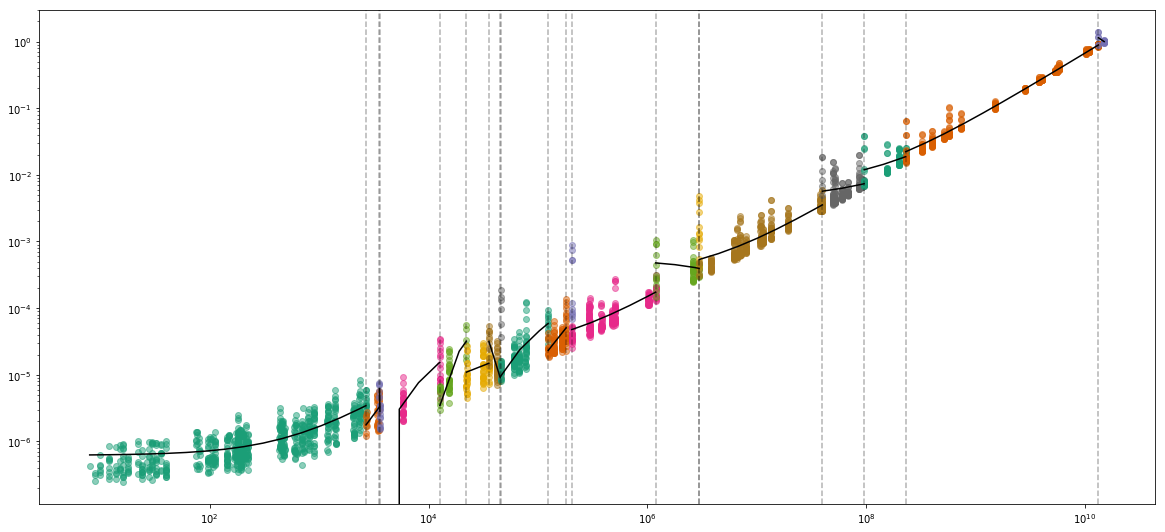

In [7]:
reg.plot_dataset(log=True)

In [8]:
reg.auto_simplify()

-inf < x ≤ 1.324e+10
	y ~ 6.717e-11x + 1.107e-03
1.324e+10 < x ≤ inf
	y ~ -8.413e-11x + 2.254e+00

The regression we get is obviously overfitting the data, the auto-simplifaction is also wrong.

In [9]:
simplifications = reg.simplify()
simplifications

,AIC,BIC,RSS,nb_breakpoints,regression
0,-2187.877612,-1746.168176,0.416471,18,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
1,-2195.877612,-1777.726012,0.416471,17,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
2,-2203.877611,-1809.283848,0.416471,16,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
3,-2211.877609,-1840.841683,0.416471,15,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
4,-2219.877597,-1872.399507,0.416471,14,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
5,-2227.877582,-1903.957329,0.416471,13,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
6,-2235.877555,-1935.515139,0.416471,12,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
7,-2243.877472,-1967.072892,0.416471,11,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
8,-2251.877186,-1998.630442,0.416471,10,"((8, 4.332142939814834e-07), (9, 2.52452951388..."
9,-2259.877095,-2030.188188,0.416471,9,"((8, 4.332142939814834e-07), (9, 2.52452951388..."


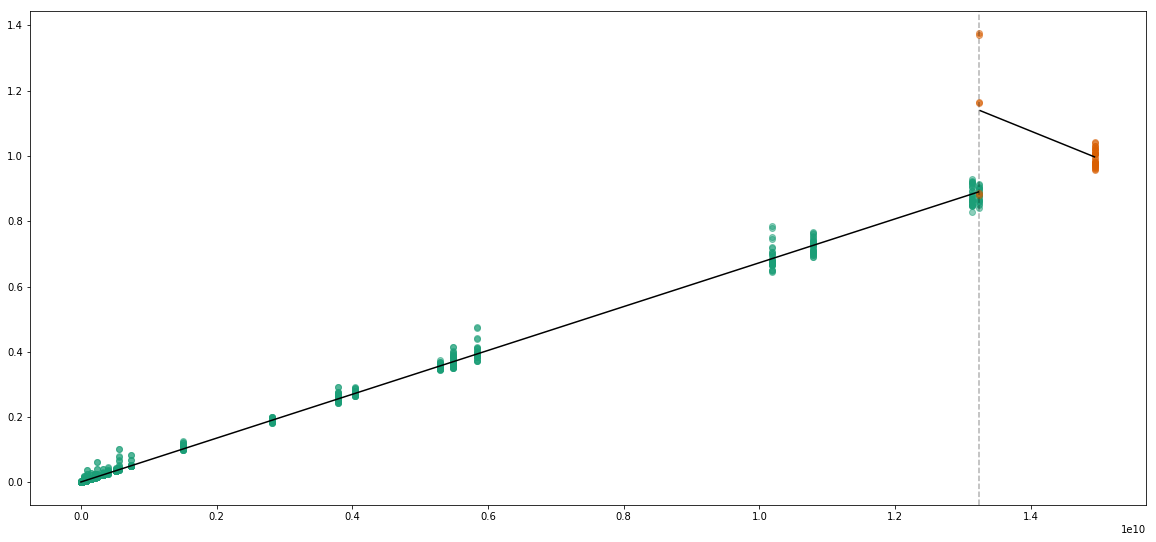

In [10]:
simplifications.iloc[-2].regression.plot_dataset()

In [11]:
reg = simplifications.iloc[-1].regression
reg

-inf < x ≤ inf
	y ~ 6.774e-11x + 9.464e-04

## Removing the "outliers"?

In [12]:
aggr[aggr.size_product <= aggr.size_product.min() * 1.2]

,m,n,k,duration,size_product
9,1,3,3,3.182727e-07,9
67,2,2,2,4.332143e-07,8
174,3,1,3,2.524530e-07,9
187,3,3,1,3.339936e-07,9


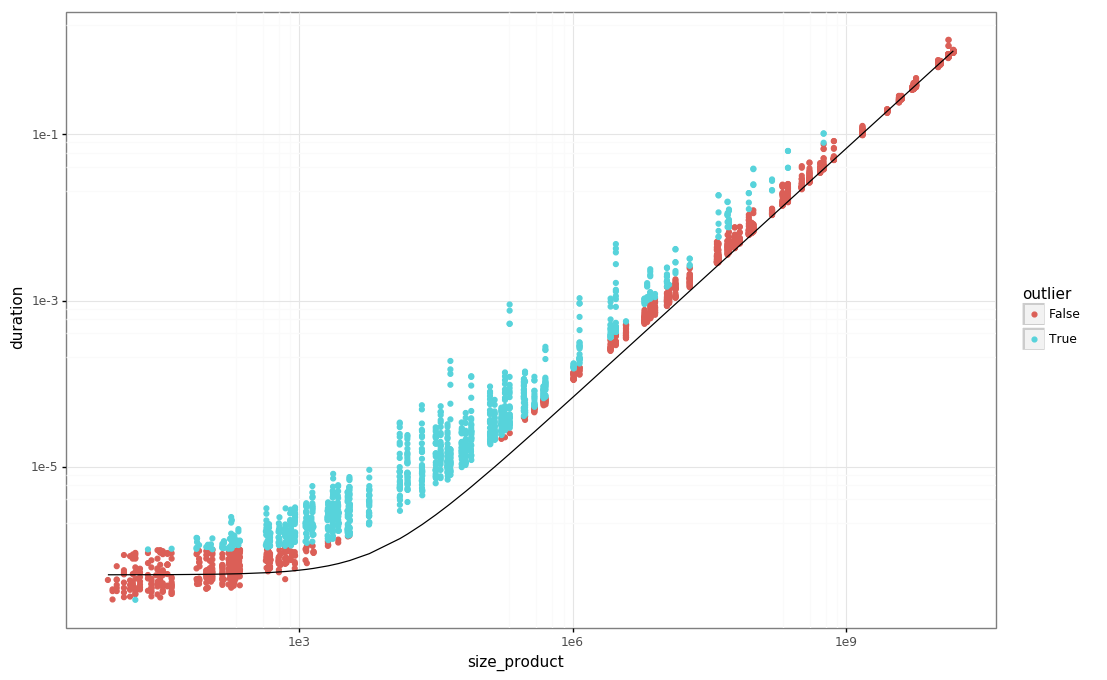

<ggplot: (8765630433249)>

In [13]:
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
aggr['pred'] = aggr['size_product'] * 6.774e-11 + 5e-7
aggr['outlier'] = (aggr['duration'] > 2*aggr['pred']) | (aggr['duration'] < 0.5*aggr['pred'])
ggplot(aggr) + geom_point(aes(x='size_product', y='duration', color='outlier')) + theme_bw() + scale_x_log10() + scale_y_log10() + geom_line(aes(x='size_product', y='pred'))

With a simple linear regression, I cannot find a nice ribbon for all the sizes. We need a more complex model.

## Manual segmented regression

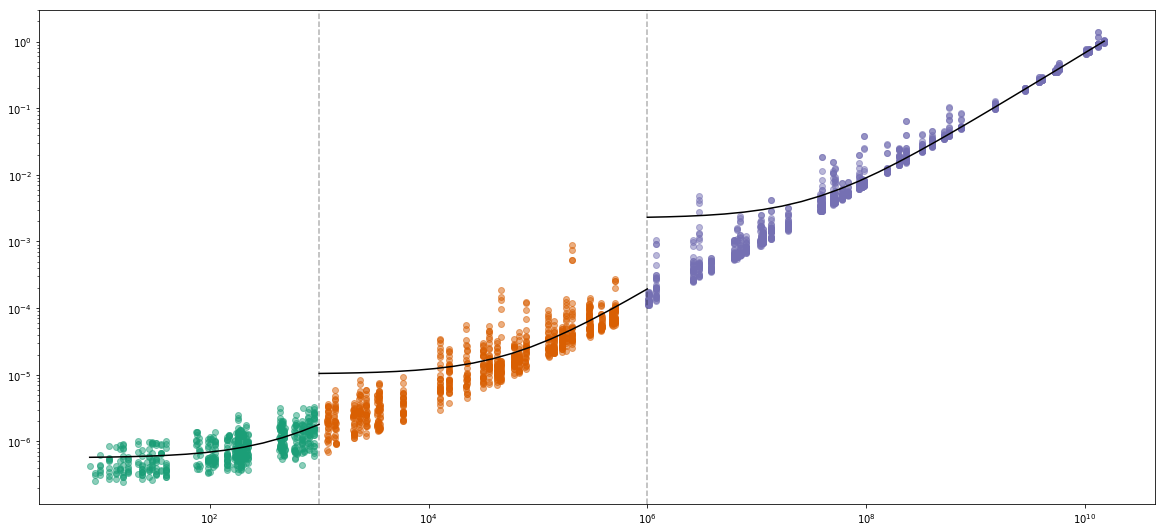

In [14]:
pytree.compute_regression(x=aggr.size_product, y=aggr.duration, breakpoints=[1e3, 1e6]).plot_dataset(log=True)

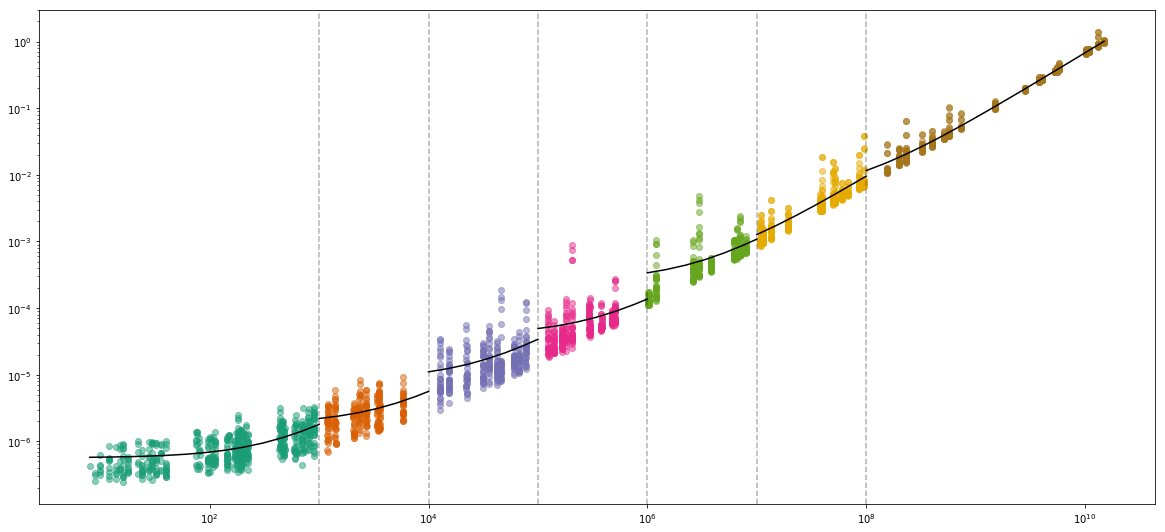

In [15]:
pytree.compute_regression(x=aggr.size_product, y=aggr.duration, breakpoints=[1e3, 1e4, 1e5, 1e6, 1e7, 1e8]).plot_dataset(log=True)

## Polynomial regression

In [16]:
aggr['mnk'] = aggr.m * aggr.n * aggr.k
aggr['mn'] = aggr.m * aggr.n
aggr['mk'] = aggr.m * aggr.k
aggr['nk'] = aggr.n * aggr.k
reg = ols(formula='duration ~ mnk + mn + mk + nk', data=aggr).fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.630e+06
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        14:59:33   Log-Likelihood:                 12223.
No. Observations:                2669   AIC:                        -2.444e+04
Df Residuals:                    2664   BIC:                        -2.441e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -7.14e-05   5.11e-05     -1.397      0.163      -0.000    2.88e-05
mnk         6.318e-11   2.36e-14   2679.566      0.000    6.31e-11    6.32e-11
mn          1.497e-10   1.05e-11     14.245      0.000    1.29e-10     1.7e-10
mk          2.109e-09   1.05e-11    200.708      0.000    2.09e-09    2.13e-09
nk          3.334e-09   1.05e-11    317.299      0.000    3.31e-09    3.35e-09
==============================================================================
Omnibus:                     1449.960   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           201829.841
Skew:                          -1.550   Prob(JB):                         0.00
Kurtosis:                      45.488   Cond. No.                     3.43e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

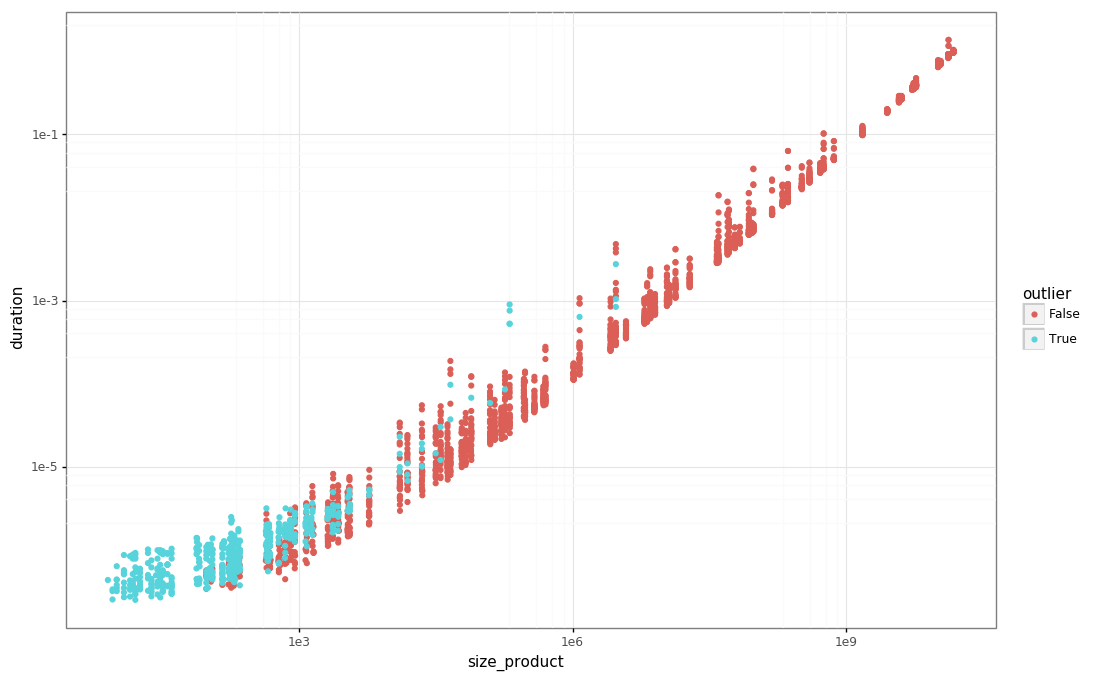

<ggplot: (8765630215386)>

In [17]:
aggr['pred'] = aggr.mnk * params.mnk + aggr.mn * params.mn + aggr.mk * params.mk + aggr.nk * params.nk
aggr['outlier'] = (aggr['duration'] > 2*aggr['pred']) | (aggr['duration'] < 0.5*aggr['pred'])
ggplot(aggr) + geom_point(aes(x='size_product', y='duration', color='outlier')) + theme_bw() + scale_x_log10() + scale_y_log10()

In [18]:
reg = ols(formula='duration ~ mnk + mn + mk + nk + m + n + k', data=aggr).fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.728e+06
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        14:59:34   Log-Likelihood:                 12265.
No. Observations:                2669   AIC:                        -2.451e+04
Df Residuals:                    2661   BIC:                        -2.447e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.865e-05   5.66e-05      1.743      0.082   -1.24e-05       0.000
mnk         6.324e-11    2.5e-14   2525.503      0.000    6.32e-11    6.33e-11
mn          1.991e-10   1.19e-11     16.747      0.000    1.76e-10    2.22e-10
mk          2.138e-09   1.19e-11    179.830      0.000    2.11e-09    2.16e-09
nk          3.336e-09   1.19e-11    280.549      0.000    3.31e-09    3.36e-09
m          -2.815e-07   3.19e-08     -8.827      0.000   -3.44e-07   -2.19e-07
n          -1.253e-07   3.19e-08     -3.928      0.000   -1.88e-07   -6.27e-08
k          -1.153e-08   3.19e-08     -0.362      0.718   -7.41e-08     5.1e-08
==============================================================================
Omnibus:                     1518.060   Durbin-Watson:                   1.483
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           200863.053
Skew:                          -1.695   Prob(JB):                         0.00
Kurtosis:                      45.364   Cond. No.                     3.86e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

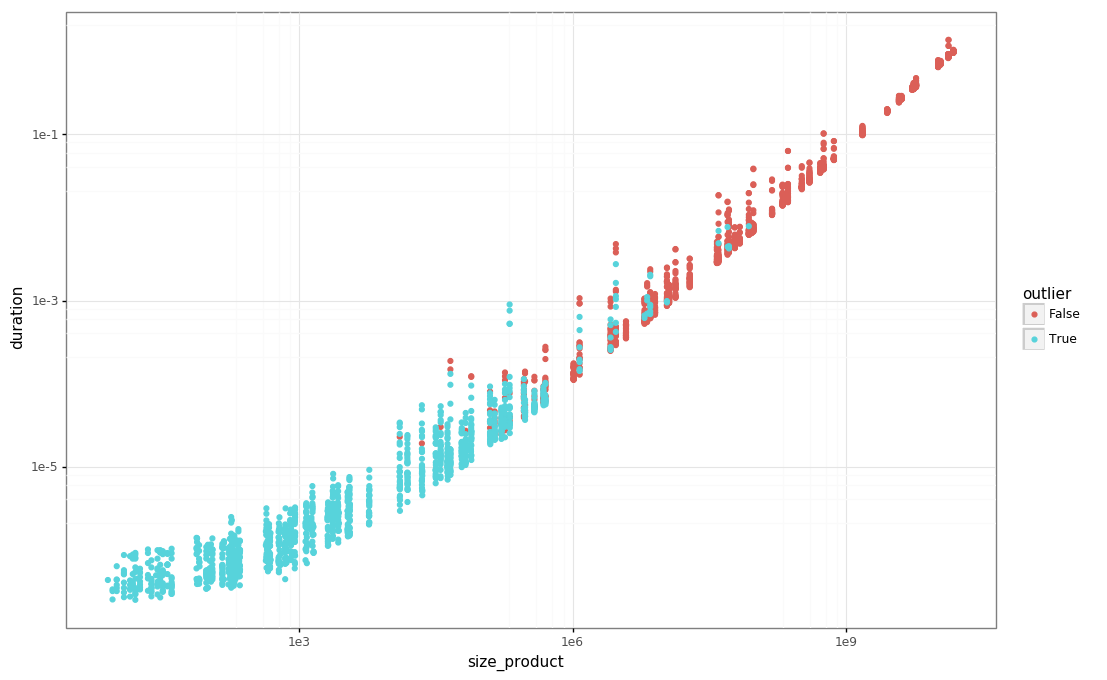

<ggplot: (8765564782996)>

In [19]:
aggr['pred'] = aggr.mnk * params.mnk + aggr.mn * params.mn + aggr.mk * params.mk + aggr.nk * params.nk + aggr.m * params.m + aggr.n * params.n + aggr.k * params.k + params.Intercept
aggr['outlier'] = (aggr['duration'] > 2*aggr['pred']) | (aggr['duration'] < 0.5*aggr['pred'])
ggplot(aggr) + geom_point(aes(x='size_product', y='duration', color='outlier')) + theme_bw() + scale_x_log10() + scale_y_log10()

## Polynomial regression with a fixed intercept

In [20]:
intercept = aggr[aggr['duration'] < aggr['duration'].quantile(0.005)].duration.mean()
intercept

2.844700396825401e-07

In [21]:
aggr['duration2'] = aggr['duration'] - intercept
reg = ols(formula='duration2 ~ mnk + mn + mk + nk + 0', data=aggr).fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              duration2   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.207e+06
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        14:59:34   Log-Likelihood:                 12222.
No. Observations:                2669   AIC:                        -2.444e+04
Df Residuals:                    2665   BIC:                        -2.441e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mnk         6.317e-11   2.33e-14   2715.705      0.000    6.31e-11    6.32e-11
mn          1.489e-10   1.05e-11     14.189      0.000    1.28e-10    1.69e-10
mk          2.108e-09   1.05e-11    200.870      0.000    2.09e-09    2.13e-09
nk          3.333e-09   1.05e-11    317.597      0.000    3.31e-09    3.35e-09
==============================================================================
Omnibus:                     1404.728   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           200628.929
Skew:                          -1.457   Prob(JB):                         0.00
Kurtosis:                      45.374   Cond. No.                         828.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

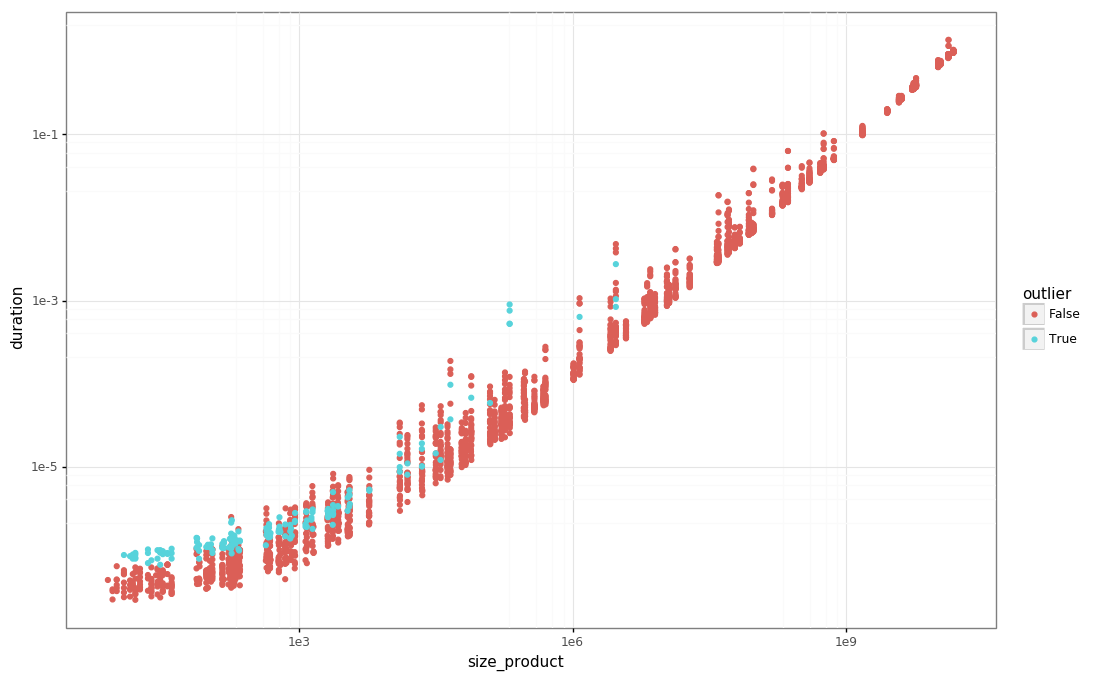

<ggplot: (-9223363271224452278)>

In [22]:
aggr['pred'] = aggr.mnk * params.mnk + aggr.mn * params.mn + aggr.mk * params.mk + aggr.nk * params.nk + intercept
aggr['outlier'] = (aggr['duration'] > 2*aggr['pred']) | (aggr['duration'] < 0.5*aggr['pred'])
ggplot(aggr) + geom_point(aes(x='size_product', y='duration', color='outlier')) + theme_bw() + scale_x_log10() + scale_y_log10()

33.16% of "outliers"


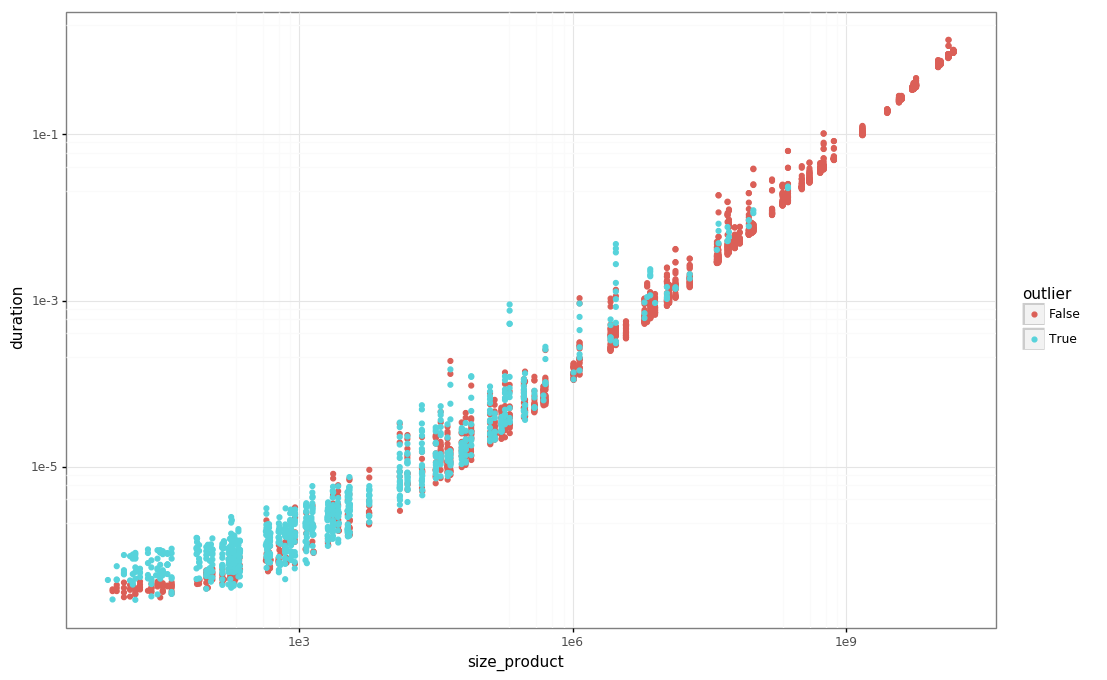

<ggplot: (8765630162622)>

In [23]:
factor = 1.2
aggr['outlier'] = (aggr['duration'] > aggr['pred']*factor) | (aggr['duration'] < aggr['pred']/factor)
print('%.2f%% of "outliers"' % (100*len(aggr[aggr.outlier])/len(aggr)))
ggplot(aggr) + geom_point(aes(x='size_product', y='duration', color='outlier')) + theme_bw() + scale_x_log10() + scale_y_log10()

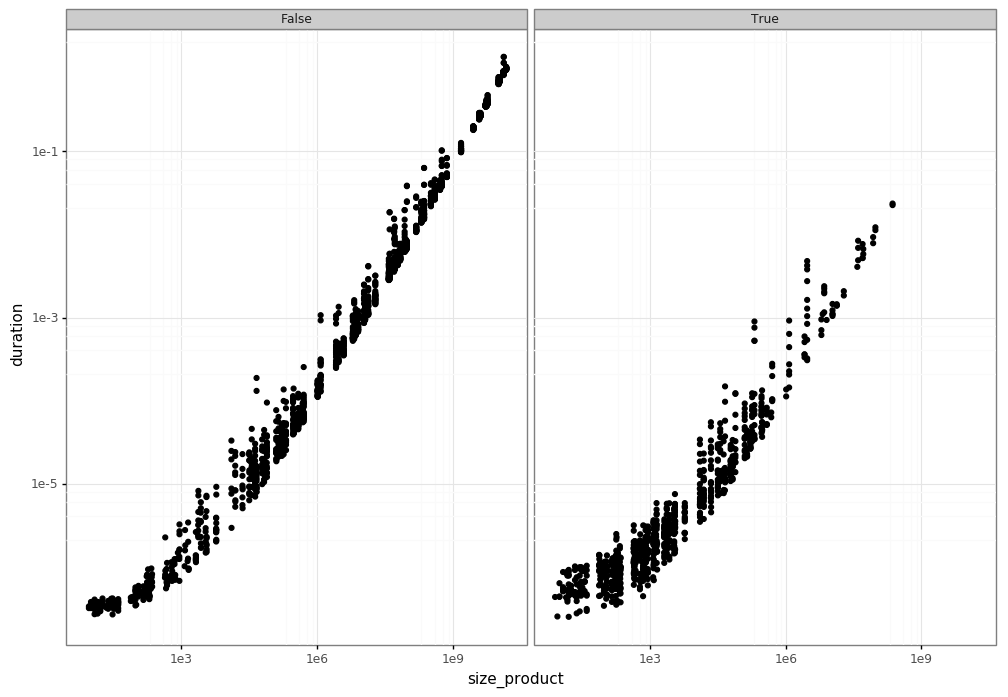

<ggplot: (8765629971432)>

In [24]:
ggplot(aggr) + geom_point(aes(x='size_product', y='duration')) + theme_bw() + scale_x_log10() + scale_y_log10() + facet_wrap('outlier')

Does not seem too bad !

In [25]:
print('real intercept: %e' % intercept)
print(params)

real intercept: 2.844700e-07
mnk    6.317136e-11
mn     1.489053e-10
mk     2.107985e-09
nk     3.332944e-09
dtype: float64


In [26]:
df['mnk'] = df.m * df.n * df.k
df['mn'] = df.m * df.n
df['mk'] = df.m * df.k
df['nk'] = df.n * df.k
df['pred'] = df.mnk * params.mnk + df.mn * params.mn + df.mk * params.mk + df.nk * params.nk + intercept

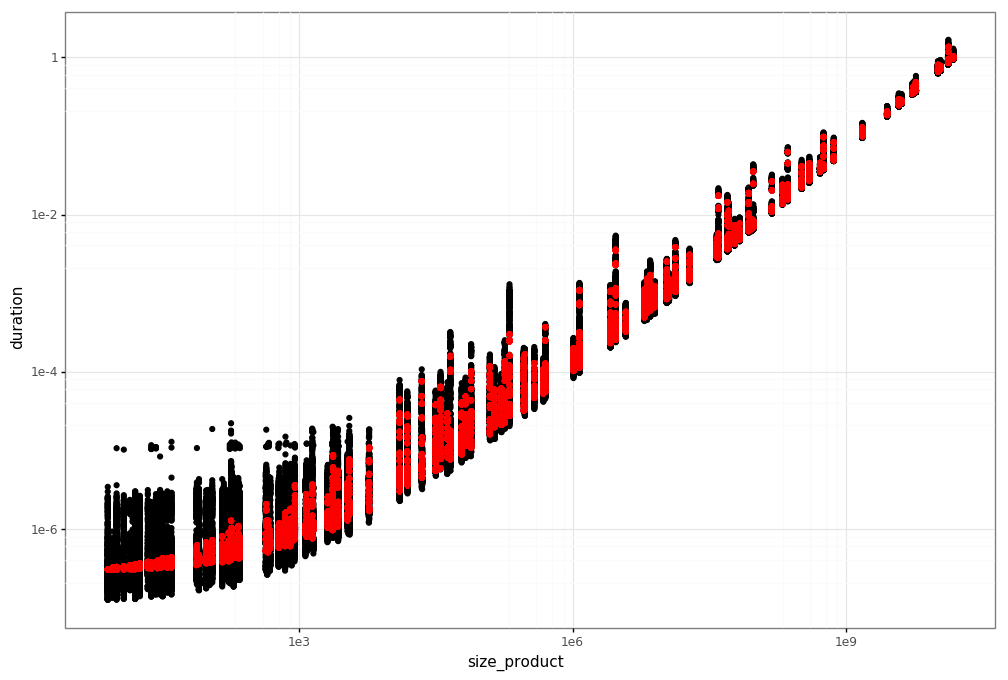

<ggplot: (-9223363271290018837)>

In [27]:
ggplot(df.sample(n=100000)) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred'), color='red', alpha=0.3) + theme_bw() + scale_x_log10() + scale_y_log10()

## Visualizing the residuals

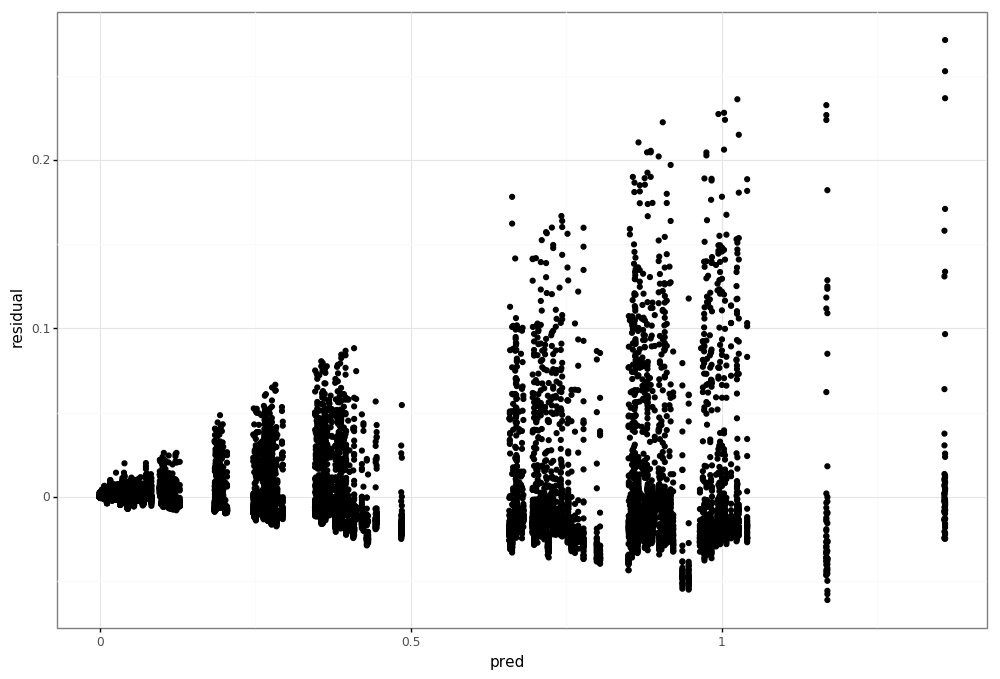

<ggplot: (8765586556010)>

In [28]:
df['residual'] = df['duration'] - df['pred']
ggplot(df.sample(n=100000), aes(x='pred', y='residual')) + geom_point() + theme_bw() #+ scale_x_log10()

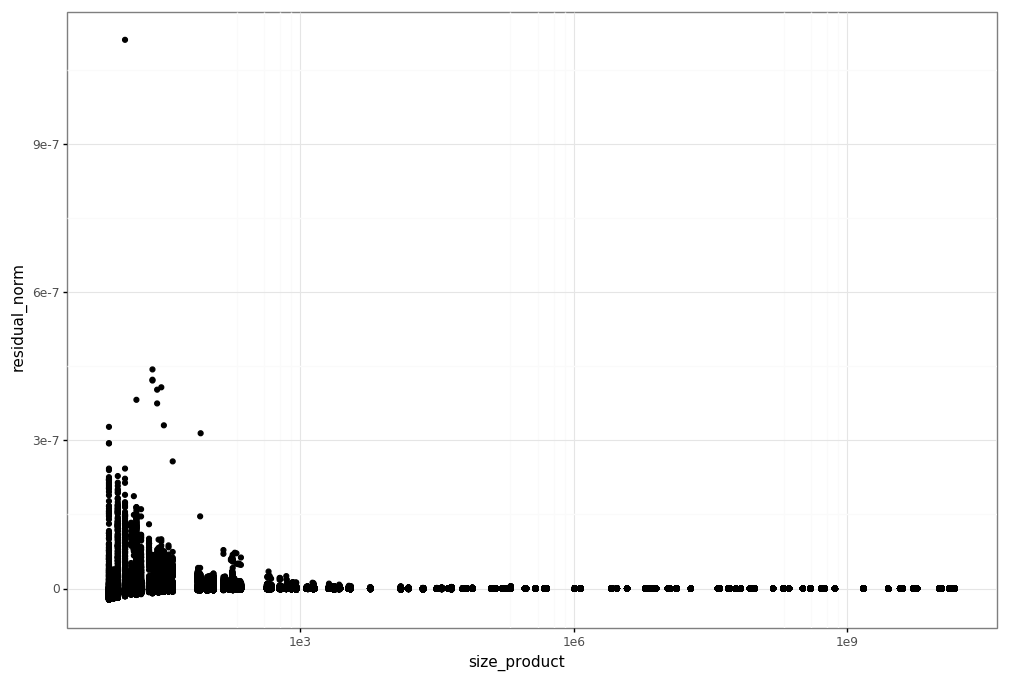

<ggplot: (8765630042211)>

In [29]:
df['residual_norm'] = (df['duration'] - df['pred']) / df['size_product']
ggplot(df.sample(n=100000), aes(x='size_product', y='residual_norm')) + geom_point() + theme_bw() + scale_x_log10()

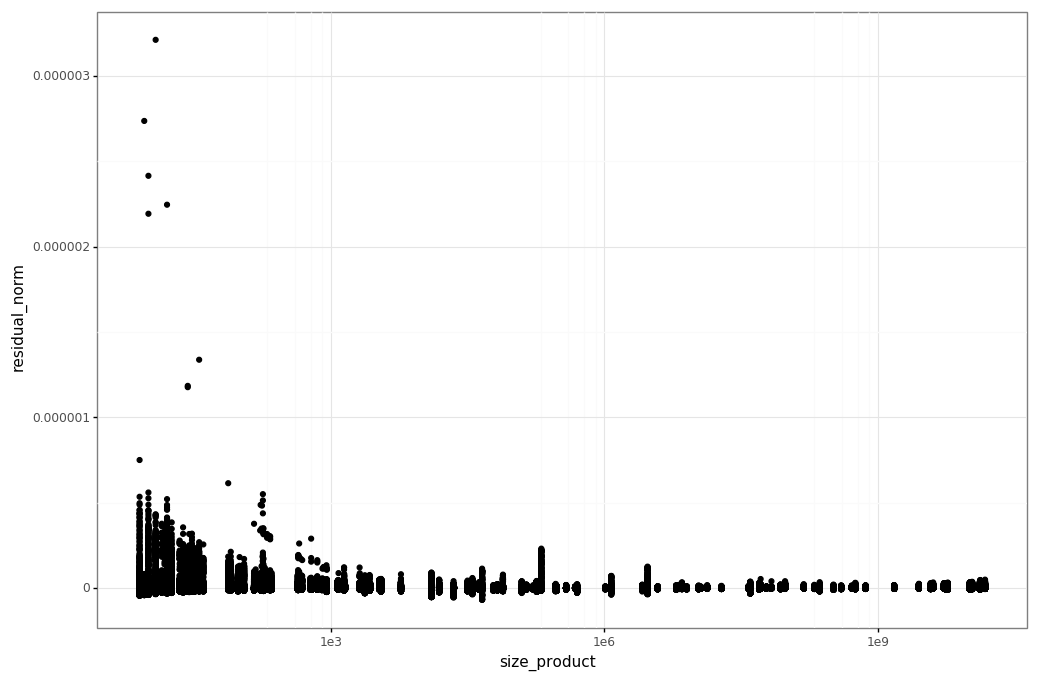

<ggplot: (-9223363271270929443)>

In [30]:
df['residual_norm'] = (df['duration'] - df['pred']) / (df['size_product']**(2/3))
ggplot(df.sample(n=100000), aes(x='size_product', y='residual_norm')) + geom_point() + theme_bw() + scale_x_log10()

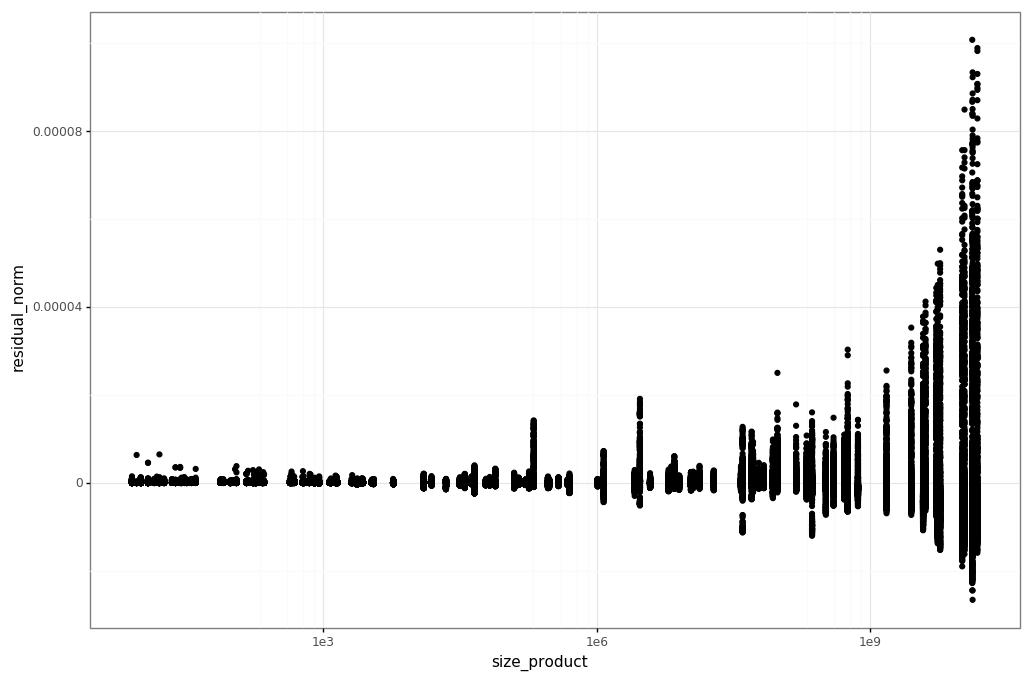

<ggplot: (-9223363271224799214)>

In [31]:
df['residual_norm'] = (df['duration'] - df['pred']) / (df['size_product']**(1/3))
ggplot(df.sample(n=100000), aes(x='size_product', y='residual_norm')) + geom_point() + theme_bw() + scale_x_log10()

## Finding a model for the residuals

In [32]:
df['residual'].mean()

-5.6432842160011965e-05

In [33]:
tmp = df.groupby(['m', 'n', 'k'])[['residual']].agg(['mean', 'std'])
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index()
tmp['mnk'] = tmp['m'] * tmp['n'] * tmp['k']
tmp['mn'] = tmp['m'] * tmp['n']
tmp['mk'] = tmp['m'] * tmp['k']
tmp['nk'] = tmp['n'] * tmp['k']
tmp.head()

,m,n,k,mean,std,mnk,mn,mk,nk
0,1,1,180,1.205724e-06,2.158202e-06,180,1,180,180
1,1,2,5,3.053633e-07,8.096932e-07,10,2,5,10
2,1,2,6,6.539127e-08,3.703941e-07,12,2,6,12
3,1,2,7,8.112543e-08,4.232391e-07,14,2,7,14
4,1,2,8,-4.286680e-08,5.663539e-07,16,2,8,16


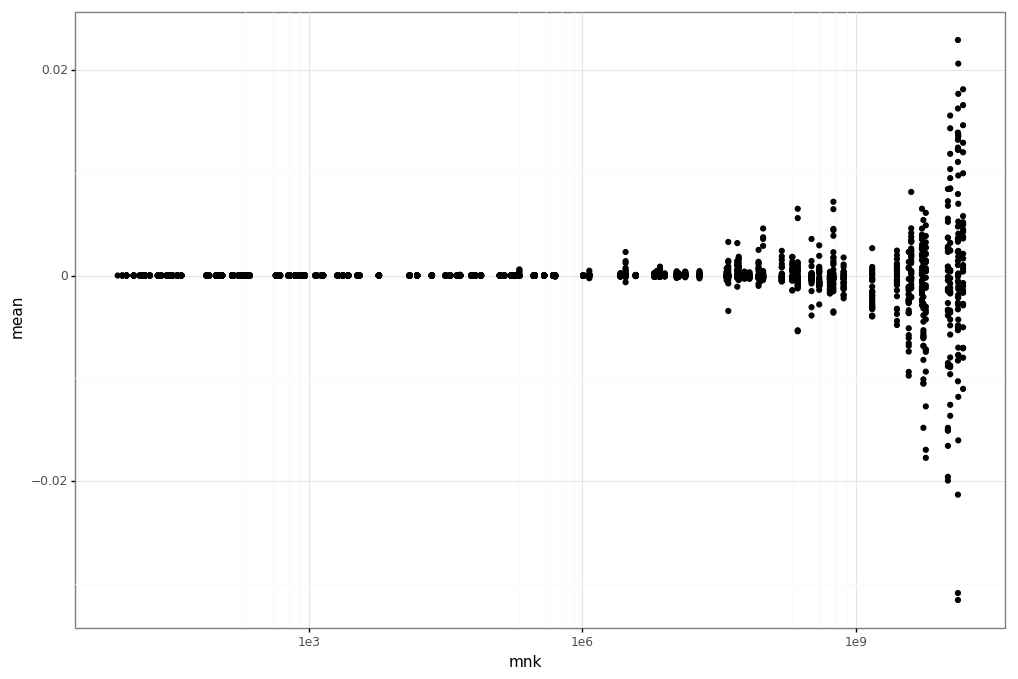

<ggplot: (8765630319992)>

In [34]:
ggplot(tmp, aes(x='mnk', y='mean')) + geom_point() + scale_x_log10() + theme_bw()

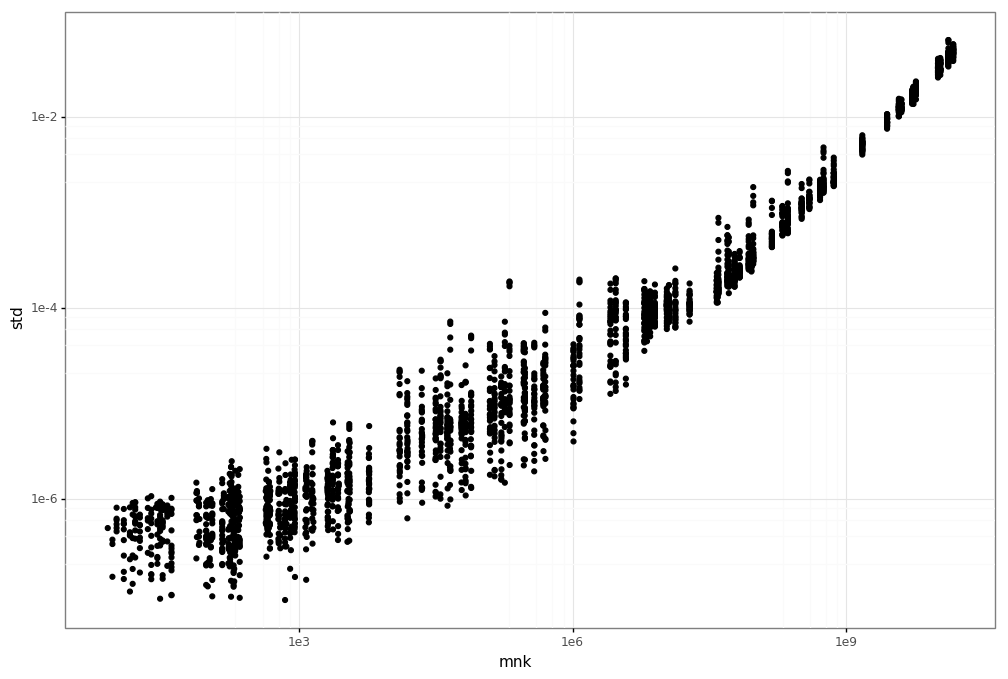

<ggplot: (-9223363271224679038)>

In [35]:
ggplot(tmp, aes(x='mnk', y='std')) + geom_point() + scale_x_log10() + scale_y_log10() + theme_bw()

In [36]:
intercept = tmp[tmp['std'] < tmp['std'].quantile(0.005)]['std'].mean()
intercept

1.0872018065879725e-07

In [37]:
tmp['std2'] = tmp['std'] - intercept
reg = ols(data=tmp, formula='std2 ~ mnk + mn + nk + mk + 0').fit()
params = reg.params
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   std2   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 7.630e+04
Date:                Tue, 05 Feb 2019   Prob (F-statistic):               0.00
Time:                        15:00:23   Log-Likelihood:                 14742.
No. Observations:                2669   AIC:                        -2.948e+04
Df Residuals:                    2665   BIC:                        -2.945e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mnk         2.977e-12   9.05e-15    329.019      0.000    2.96e-12    2.99e-12
mn          8.366e-12   4.08e-12      2.050      0.040    3.62e-13    1.64e-11
nk          9.931e-11   4.08e-12     24.332      0.000    9.13e-11    1.07e-10
mk          1.529e-10   4.08e-12     37.451      0.000    1.45e-10    1.61e-10
==============================================================================
Omnibus:                      882.028   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78654.897
Skew:                           0.602   Prob(JB):                         0.00
Kurtosis:                      29.567   Cond. No.                         828.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

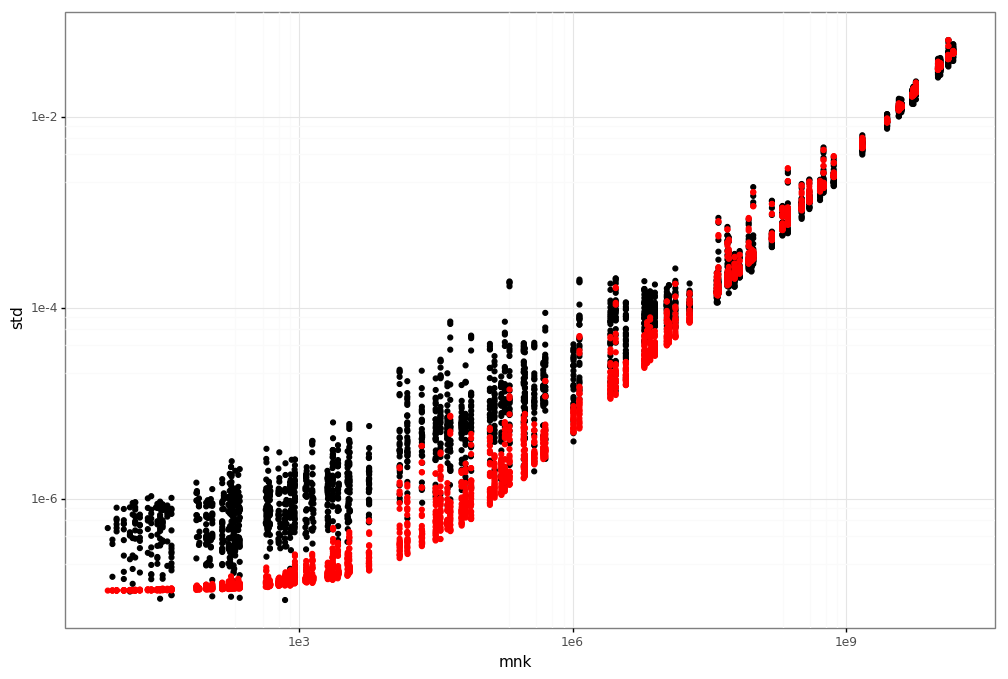

<ggplot: (-9223363271224340487)>

In [38]:
tmp['pred'] = intercept + params.mnk * tmp.mnk + params.mn * tmp.mn + params.mk * tmp.mk + params.nk * tmp.nk
ggplot(tmp, aes(x='mnk', y='std')) + geom_point() + geom_point(aes(x='mnk', y='pred'), color='red') + scale_x_log10() + scale_y_log10() + theme_bw()

In [39]:
import numpy
df['sd_noise'] = intercept + params.mnk * df.mnk + params.mn * df.mn + params.mk * df.mk + params.nk * df.nk
df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
df['noise'] *= df['sd_noise']

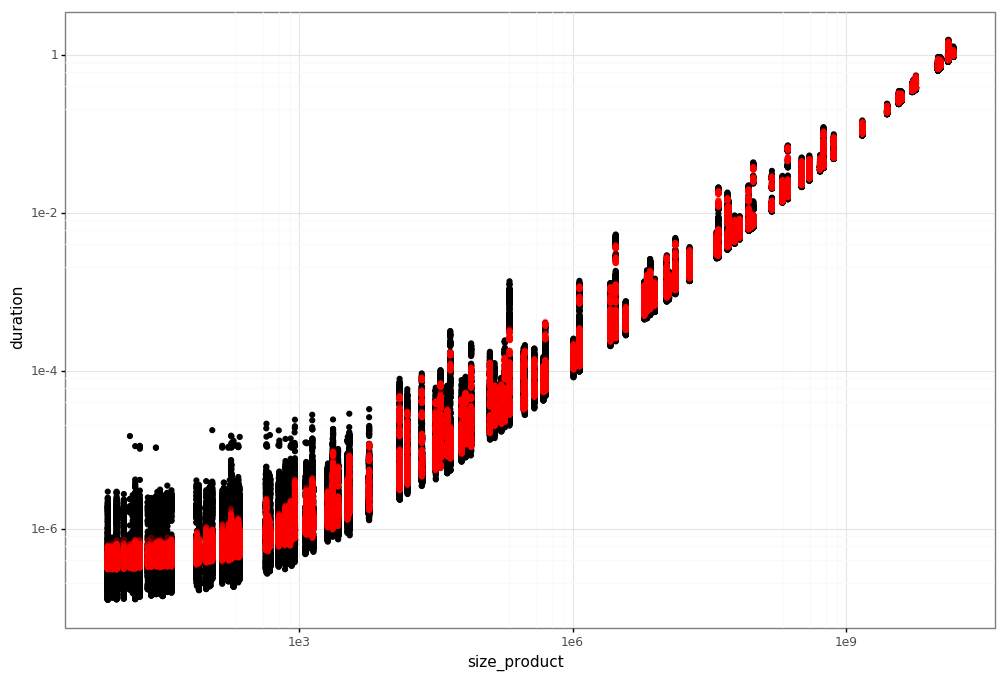

<ggplot: (-9223363271224391364)>

In [40]:
df['pred_noise'] = df['pred'] + df['noise']
ggplot(df.sample(n=100000)) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw() + scale_x_log10() + scale_y_log10()

In [41]:
df['sigma_noise'] = (df['sd_noise']**2 / (1-2/numpy.pi))**(1/2) # We have \sigma = sqrt(Var(Y) / (1-2/\pi))
df['noise'] = numpy.abs(numpy.random.normal(0, 1, len(df)))
df['noise'] *= df['sigma_noise']

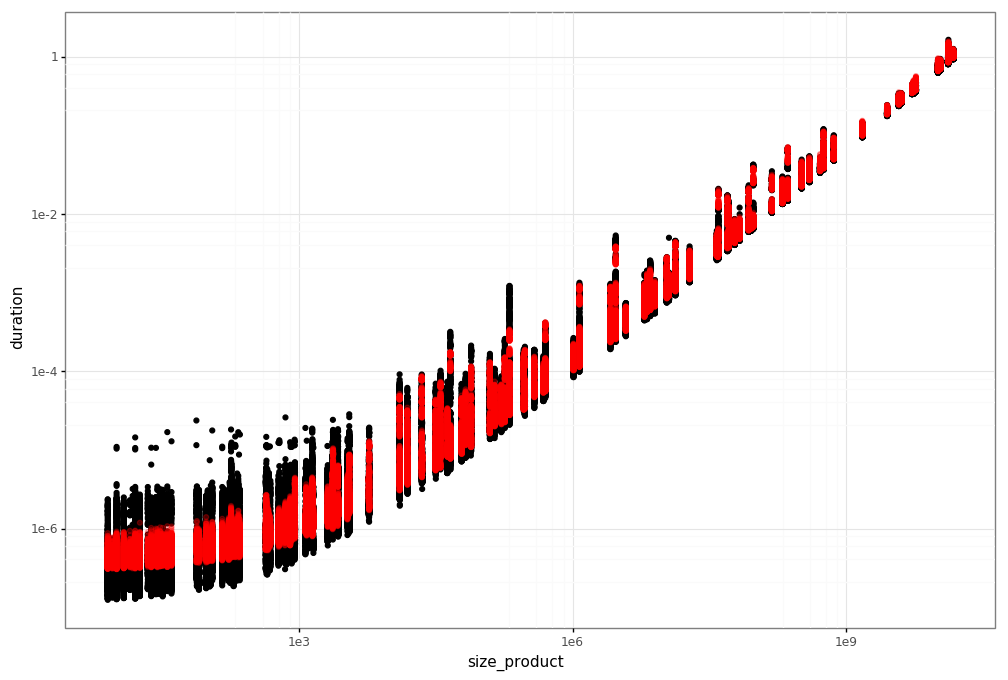

<ggplot: (8765630196221)>

In [42]:
df['pred_noise'] = df['pred'] + df['noise']
ggplot(df.sample(n=100000)) + geom_point(aes(x='size_product', y='duration')) + geom_point(aes(x='size_product', y='pred_noise'), color='red', alpha=0.3) + theme_bw() + scale_x_log10() + scale_y_log10()

In [43]:
print(intercept)
params

1.0872018065879725e-07


mnk    2.976703e-12
mn     8.365868e-12
nk     9.931248e-11
mk     1.528598e-10
dtype: float64